In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import json
import re
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score
from ipywidgets import interactive, interact
from IPython.display import display
import seaborn as sns
import os

# Open Dataset

Choose the feature only we need

In [2]:
df = pd.read_csv('demographic.csv')
df = df.drop('index', axis=1)

df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_call_log_stats',
    'ph_total_contacts',
    'de_date_joined',
    'fb_last_updated_date',
    'ph_app_list',
    'fb_dob',
    'fb_relation',
    'fb_gender'
]].copy()

/tmp/ipykernel_74109/195087651.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('demographic.csv')


Here we fill null values with unstated so the model can learn it also

In [3]:
df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')

For fb relation, we also prevent high cardinality by assigning some category to other that is related

In [4]:
df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

### Feature Engineering

We also create new feature: fb_age which is the difference between the date of birth in FB and date joined. For the EDA information that stated we need to find difference first, xgboost can handle it automatically and find pattern as long as we provide the root features (fb_age and the de_age)

In [5]:
df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365

Then the interesting part. For app list, we extract several information about the user apps like gambling apps, clone, mod, finance risky, invest, adult and suspicious utility by using keywords. The idea behind finance risky and invest is my concern that they will use our bnpl to pay their margin or just fraudsters getting much money by more financial apps.

In [6]:
categories = {
    "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
    "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
    "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
    "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
    "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
    "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
    "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
}
# Create binary columns for each category
for cat, keywords in categories.items():
    df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
        lambda x: int(any(kw in x for kw in keywords))
    )

In [7]:
df_bs["join_second"] = pd.to_datetime(df_bs.de_date_joined, dayfirst=True).dt.hour*3600 + pd.to_datetime(df_bs.de_date_joined, dayfirst=True).dt.minute*60

Then the last update days relative to the date joined

In [8]:
joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")

df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
del joined, updated

In [9]:
def normalize_os(os_str):
    if os_str is np.nan:
        return None
    
    # --- Android ---
    if os_str.startswith("Android"):
        match = re.search(r"Android\s(\d+)(?:\.(\d+))?", os_str)
        if match:
            major = int(match.group(1))
            minor = match.group(2)

            if major < 4:
                return "Android Legacy (less than 4)"
            elif major == 4:
                if minor in ["0", "1", "2", "3"]:
                    return "Android 4 (Jelly Bean/ICS)"
                elif minor == "4":
                    return "Android 4.4 (KitKat)"
                else:
                    return "Android 4 (Jelly Bean/ICS)"  # fallback
            elif major == 5:
                return "Android 5 (Lollipop)"
            elif major == 6:
                return "Android 6 (Marshmallow)"
            elif major == 7:
                return "Android 7 (Nougat)"
            elif major >= 8:
                return "Android 8+ (Oreo & later)"
    
    # --- iOS ---
    if os_str.startswith("iOS"):
        match = re.search(r"iOS\s(\d+)", os_str)
        if match:
            major = int(match.group(1))
            if major in [6, 7]:
                return "iOS 6-7"
            elif major in [8, 9]:
                return "iOS 8-9"
            elif major >= 10:
                return "iOS 10+"
    
    return "Other/Unknown"

Then other device info. Here i take 15% time of the project to really self labelling the data, thinking the features i got will improve it. The long explanation is at device.ipynb where I used external dataset (gsmarena) to map to the phone feature. This also to prevent high cardinality in production if we use all of the phone category although xgboost can handle that in research. Alas, this time taking big research of FE left me with lesser time to explore this rich dataset. There are more things that can be tried to explore in the cleaned dataset, should be.  

Here we try to use phone price, whether its discontinued/cancelled, bucketed platform os (see normalize os function above), and sim number (back then dual sim was a new thing i believe).

In [10]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device

df_mkt_gsm = pd.read_csv('marketing_gsm_clean.csv')
df_mkt_gsm = df_mkt_gsm[[
    'device_codename',
    'brand',
    'misc_price',
    'platform_os',
    'launch_status',
    'body_sim',
    'Retail Branding',
]]
df_mkt_gsm['Retail Branding'] = df_mkt_gsm['Retail Branding'].fillna('Unfound')
# Clean one error
df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.replace({'<c2><a3><e2><80><89>141.60 / $<e2><80><89>149.00':'About 180 EUR'})
# Extract number only
df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.str.extract(r"(\d+)")
# Get os
df_mkt_gsm.platform_os = df_mkt_gsm.platform_os.map(normalize_os)
# Get continuation status
df_mkt_gsm["discontinued"] = df_mkt_gsm.launch_status.str.contains("Discontinued|Cancelled", case=False)
# Get sim number
df_mkt_gsm.body_sim = df_mkt_gsm.body_sim.str.contains('Dual|Triple', case=False)
df_bs = df_bs.merge(df_mkt_gsm, how='left', on=['device_codename', 'brand'])

Call log stats feature engineering

In [11]:
df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
df_call_log_stats = df_call_log_stats.fillna(0)
df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
del df_call_log_stats

Drop the unused column and assign several things as str so it can be dummied as binary feature

In [12]:
df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob', 'launch_status'], axis=1)

df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)

Prepare before modelling by splitting data into train and test, and use stratify y so the composition by flag bad is more or less the same

In [13]:
df_bs = pd.get_dummies(df_bs)

y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
del X, y

### Modelling

In [14]:
model = XGBClassifier(
    # tree_method="hist",  # use histogram, works for both CPU and GPU
    # device="cuda:0"      # instead of gpu_id
)
model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

average_precision_score(y_test, y_proba)

0.29499343685043417

In [15]:
model = LGBMClassifier()
model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

average_precision_score(y_test, y_proba)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4256, number of negative: 28561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 32817, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129689 -> initscore=-1.903712
[LightGBM] [Info] Start training from score -1.903712


0.31703905855674425

As its faster and higher in baseline result, i will promote this model to parameter tuning.

In [16]:
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

grid = {
    "num_leaves": [31, 63, 127],          # tree complexity
    "max_depth": [-1, 10, 20],            # unlimited vs medium vs deep
    "learning_rate": [0.01, 0.05, 0.1],   # conservative to faster
    "n_estimators": [100, 300, 500],      # number of boosting rounds
    "subsample": [0.8, 0.9, 1.0],         # row sampling
    "colsample_bytree": [0.8, 0.9, 1.0],   # feature sampling
    "scale_pos_weight": [None, scale_pos_weight]
}
grid_search = GridSearchCV(LGBMClassifier(verbosity=-1, random_state=42, n_jobs=os.cpu_count()-8), grid, scoring='average_precision', verbose = 2, cv=5)

In [17]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, scale_pos_weight=None, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, scale_pos_weight=None, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, scale_pos_weight=None, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, scale_pos_weight=None, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, scale_pos_weight=None, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, scale_pos_weight=None, subsample=0.9; total time=   0.2s
[CV] 

,estimator,LGBMClassifie... verbosity=-1)
,param_grid,"{'colsample_bytree': [0.8, 0.9, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 10, ...], 'n_estimators': [100, 300, ...], ...}"
,scoring,'average_precision'
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [18]:
grid_search.best_score_

np.float64(0.3277603722751002)

In [19]:
grid_search.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': -1,
 'n_estimators': 300,
 'num_leaves': 31,
 'scale_pos_weight': None,
 'subsample': 0.8}

The choosen model

In [16]:
# Quick test model
model = LGBMClassifier(
    colsample_bytree= 0.9,
    learning_rate= 0.05,
    max_depth= -1,
    n_estimators= 300,
    num_leaves= 31,
    # scale_pos_weight=(scale_pos_weight)**0.5,
    # is_unbalance=True,
    subsample= 0.8,
)

# Fit
model.fit(X_train, y_train)

# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate
ap = average_precision_score(y_test, y_proba)
print("Result:", ap)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4256, number of negative: 28561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 32817, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129689 -> initscore=-1.903712
[LightGBM] [Info] Start training from score -1.903712
Result: 0.32374467989417155


### Evaluation

We can set recall threshold around 80% to getting all the true positives more for a thumb rule. It can be adjusted also by discussion with management and credit risk team regarding the threshold and user flow each time, and if we have also other metric that measures directly to opportunity cost lost or potential gain.

In [17]:
performance = pd.DataFrame()
performance['y_proba'] = model.predict_proba(X_test)[:,1]
# performance['y_proba'] = grid_search.best_estimator_.predict_proba(X_test)[:,1]
performance['y_test'] = y_test.reset_index(drop=True)
performance.index = y_test.index
performance;

In [18]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, log_loss

table2 = performance.copy()
table2['y_proba'] = table2['y_proba']*100

@interact(threshold=(0,100,0.01))
def proba_fun(threshold=8.50):
    plt.subplots(1, figsize=(8,4))
    sns.histplot(data=table2, x='y_proba', hue='y_test', kde=True, binwidth=1)
    plt.axvline(threshold, color='red')
    plt.show()
    
    table2['y_pred'] = table2.y_proba.map(lambda x: 1 if x>threshold else 0)
    a = precision_score(table2.y_test, table2.y_pred)*100
    b = recall_score(table2.y_test, table2.y_pred)*100
    c = confusion_matrix(table2.y_test, table2.y_pred)
    tn, fp, fn, tp = c.ravel()
    percent_rows = (fp+tp)*100/(fp+tp+tn+fn)
    d = pd.DataFrame(c, index=['Real 0', 'Real 1'], columns=['Predict 0', 'Predict 1'])
    e = average_precision_score(performance.y_test, performance.y_proba)

    # -------------------------------
    # KS Statistic (distribution separation)
    # https://claude.ai/chat/aabc901c-ce88-4e34-b89e-83222be50538
    # -------------------------------
    ks_stat, ks_pvalue = ks_2samp(
        table2.loc[table2['y_test']==1, 'y_proba'],
        table2.loc[table2['y_test']==0, 'y_proba']
    )
    
    # KS via ROC (alternative, more common in credit risk decks)
    fpr, tpr, thresholds = roc_curve(table2.y_test, table2.y_proba/100)
    ks_from_roc = max(tpr - fpr)

    # -------------------------------
    # Log Loss (uses raw probabilities)
    # https://claude.ai/chat/aabc901c-ce88-4e34-b89e-83222be50538
    # Probabilities is useful for pricing tier. Logloss "evaluates" how much the probabilities is applicable to the pricing tier
    # Depends on company but in general: Excellent: 0.1 - 0.3 | Good: 0.3 - 0.5 | Okay: 0.5 - 0.7 | Poor: 0.7 - 1.0 | Terrible: 1.0+
    # -------------------------------
    ll = log_loss(table2.y_test, table2.y_proba/100)
    
    print('Precision :', '%.2f' % a)
    print('Recall :', '%.2f' % b)
    
    print('\n')
    print(f"KS (two-sample test) : {ks_stat:.4f}")
    print(f"KS (from ROC)        : {ks_from_roc:.4f}")
    # KS p-value If you want to statistically test whether two models produce significantly different score distributions.
    # Example: Model A vs Model B → compute KS statistic for both → use KS p-value to see if the difference is statistically significant.
    # Not really useful here below
    print(f"KS p-value        : {ks_pvalue:.4f}")
    print(f"Log Loss : {ll:.4f}")
    
    # print('Percent_rows :', '%.2f' % percent_rows)
    print('\n')
    print('AUPRC :', '%.4f' % e)
    print(f"Approved (predicted good): {tn+fn}")
    print(f"Rejected (predicted bad): {tp+fp}")
    display(d)

interactive(children=(FloatSlider(value=8.5, description='threshold', step=0.01), Output()), _dom_classes=('wi…

![alt text](image-4.png)

Out of all our test dataset, we reject 4120 people to get that 80% recall threshold by rejecting people having bad score bigger than 8.70

In [19]:
from sklearn.metrics import roc_curve, log_loss

# Assume table2 has:
# table2['y_test']  = true labels (0/1)
# table2['y_proba'] = predicted probabilities * 100

@interact(threshold=(0,100,0.1))
def proba_fun(threshold=8.50):
    y_true = table2['y_test']
    y_prob = table2['y_proba'] / 100  # scale back to [0,1]
    
    # Confusion Matrix at threshold
    table2['y_pred'] = (table2['y_proba'] > threshold).astype(int)
    cm = confusion_matrix(y_true, table2['y_pred'])
    
    # -------------------------------
    # Log Loss
    # -------------------------------
    ll = log_loss(y_true, y_prob)
    
    # -------------------------------
    # KS Curve (using ROC)
    # -------------------------------
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    ks_values = tpr - fpr
    ks_max = ks_values.max()
    ks_max_idx = ks_values.argmax()
    
    # -------------------------------
    # Plot KS curve
    # -------------------------------
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, tpr, label="TPR (Sensitivity)")
    plt.plot(thresholds, fpr, label="FPR (1 - Specificity)")
    plt.plot(thresholds, ks_values, label="KS Curve", color="purple")
    plt.axhline(0, color='black', linestyle='--')
    
    # Mark KS max point (its more like max tpr-fpr difference, KS is threshold-independent)
    plt.scatter(thresholds[ks_max_idx], ks_values[ks_max_idx], 
                color="red", s=80, label=f"Max KS = {ks_max:.3f}")
    
    # Mark current threshold
    plt.axvline(threshold/100, color="orange", linestyle="--", 
                label=f"Current Threshold = {threshold/100:.2f}")
    
    plt.xlabel("Threshold (probability)")
    plt.ylabel("Rate")
    plt.title("KS Curve (TPR - FPR)")
    plt.legend()
    plt.grid()
    
    # -------------------------------
    # Print summary
    # -------------------------------
    print(f"Log Loss : {ll:.4f}")
    print(f"Max KS   : {ks_max:.4f} (at threshold {thresholds[ks_max_idx]:.2f})")
    print("Note: its more like max tpr-fpr difference, KS itself is threshold-independent, property of a model regardless threshold")
    print("Confusion Matrix at current threshold:")
    display(pd.DataFrame(cm, 
                         index=['Real 0','Real 1'], 
                         columns=['Pred 0','Pred 1']))


interactive(children=(FloatSlider(value=8.5, description='threshold'), Output()), _dom_classes=('widget-intera…

# Comparation of KS to maximum F1 score

1. Maximum F1 score is slow to calculate as it needs to iterate
2. KS specialize in ranking something. Maximum F1 score wasnt designed to specialize in that thing. KS emerges in BNPL, door-to-door sales case, credit scoring with CA
3. F1 score rather is used to be maximized at different threshold, for use case where all users can be checked like medical where all patient need to be checked

In [20]:
from sklearn.metrics import roc_curve, log_loss, f1_score

# Assume table2 has:
# table2['y_test']  = true labels (0/1)
# table2['y_proba'] = predicted probabilities * 100

@interact(threshold=(0,100,0.1))
def proba_fun(threshold=8.50):
    y_true = table2['y_test']
    y_prob = table2['y_proba'] / 100  # scale back to [0,1]

    # Predictions at current threshold
    y_pred = (y_prob > threshold/100).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # -------------------------------
    # Log Loss
    # -------------------------------
    ll = log_loss(y_true, y_prob)

    # -------------------------------
    # KS Curve (using ROC)
    # -------------------------------
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    ks_values = tpr - fpr
    ks_max = ks_values.max()
    ks_max_idx = ks_values.argmax()

    # -------------------------------
    # F1 Score vs Threshold
    # -------------------------------
    f1_scores = []
    for thr in thresholds:
        preds_thr = (y_prob > thr).astype(int)
        f1_scores.append(f1_score(y_true, preds_thr))

    # -------------------------------
    # Plotting
    # -------------------------------
    fig, ax1 = plt.subplots(figsize=(9,6))

    # KS curves
    ax1.plot(thresholds, tpr, label="TPR (Sensitivity)")
    ax1.plot(thresholds, fpr, label="FPR (1 - Specificity)")
    ax1.plot(thresholds, ks_values, label="KS Curve", color="purple")
    ax1.plot(thresholds, f1_scores, color="green", linestyle="--", label="F1 Score")
    ax1.scatter(thresholds[ks_max_idx], ks_values[ks_max_idx],
                color="red", s=80, label=f"Max KS = {ks_max:.3f}")
    ax1.axvline(threshold/100, color="orange", linestyle="--",
                label=f"Current Threshold = {threshold/100:.2f}")
    ax1.set_xlabel("Threshold (probability)")
    ax1.set_ylabel("Rate")
    ax1.grid()
    ax1.legend(loc="upper right")

    # -------------------------------
    # Print summary
    # -------------------------------
    print(f"Log Loss : {ll:.4f}")
    print(f"Max KS   : {ks_max:.4f} (at threshold {thresholds[ks_max_idx]:.2f})")
    print(f"F1 Score at current threshold {threshold/100:.2f} : {f1_score(y_true, y_pred):.4f}")
    print("Note: its more like max tpr-fpr difference, KS itself is threshold-independent, property of a model regardless threshold")
    print("Confusion Matrix at current threshold:")
    display(pd.DataFrame(cm, 
                         index=['Real 0','Real 1'], 
                         columns=['Pred 0','Pred 1']))


interactive(children=(FloatSlider(value=8.5, description='threshold'), Output()), _dom_classes=('widget-intera…

# Model & Output Explainability/Interpretability

In [35]:
import shap

In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test) # explainer.shap_values(X_test)

### Feature Importance

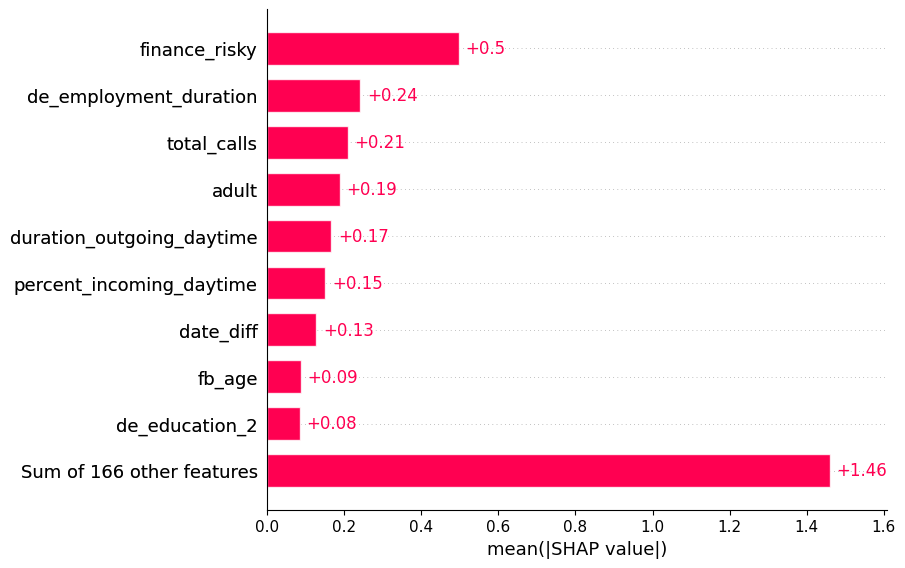

In [48]:
shap.plots.bar(shap_values)

### Explaining Why a Person Good/Bad

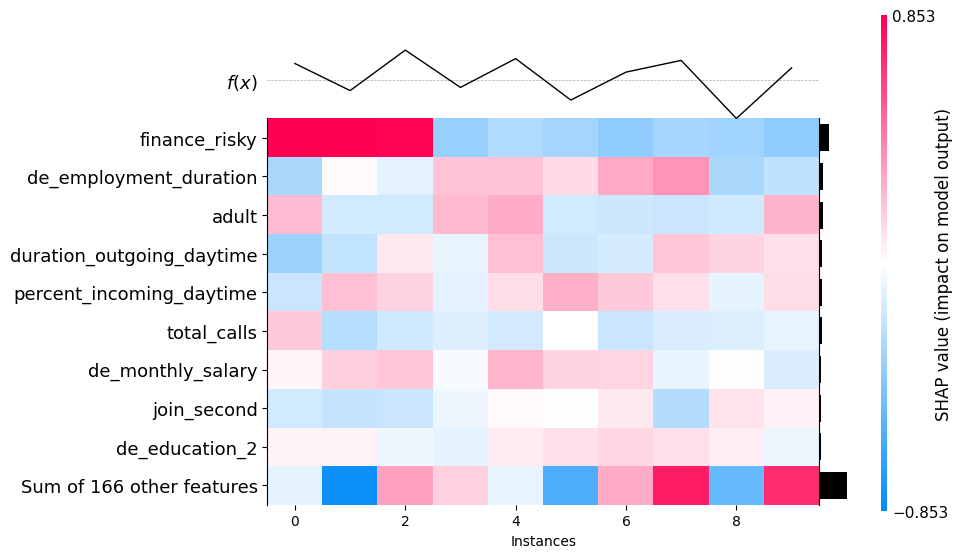

In [64]:
shap.plots.heatmap(shap_values[:10]);

Notice the 0th person

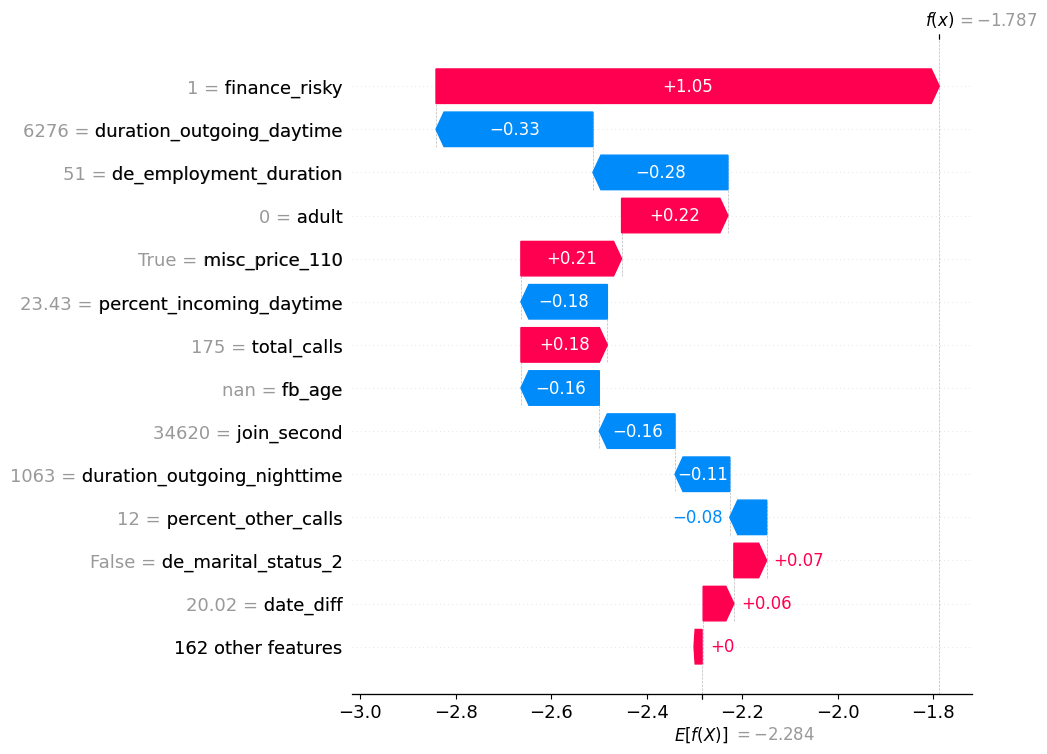

In [73]:
shap.plots.waterfall(shap_values[0], max_display=14)

### Explaining Nonlinearity & Interaction

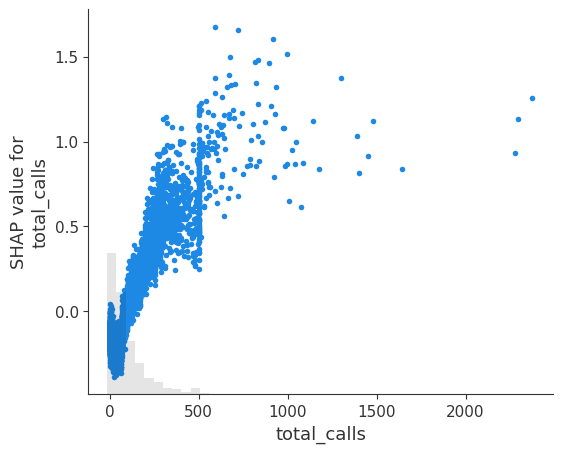

In [72]:
shap.plots.scatter(shap_values[:, "total_calls"])

/home/alvinrach/.jupytervenv/lib/python3.12/site-packages/shap/plots/_scatter.py:452: RuntimeWarning: invalid value encountered in greater
  min_dist = np.min(diffs[diffs > 1e-8])


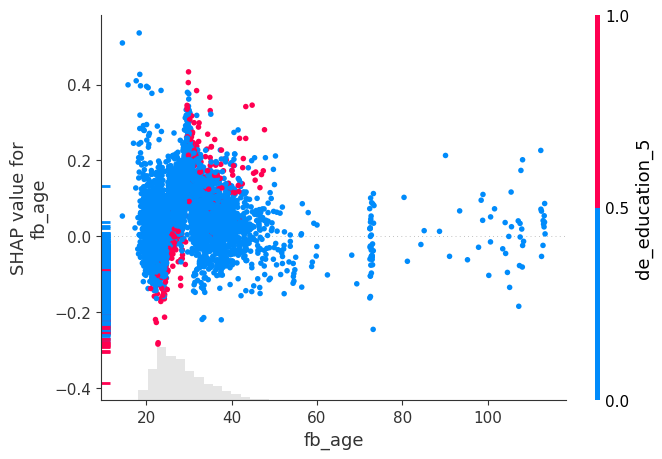

In [57]:
shap.plots.scatter(shap_values[:, "fb_age"], color=shap_values)

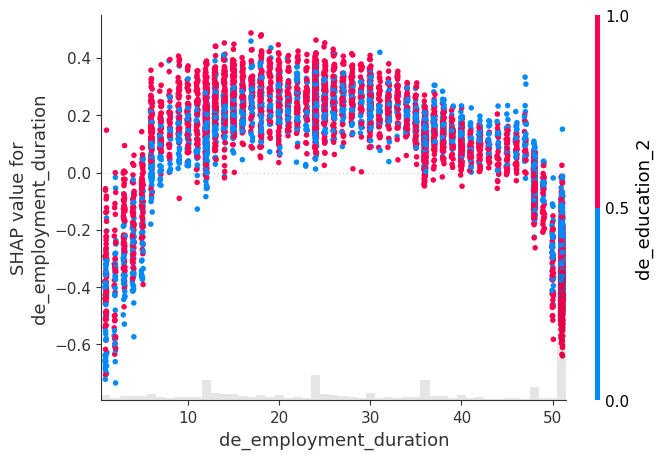

In [55]:
shap.plots.scatter(shap_values[:, "de_employment_duration"], color=shap_values)

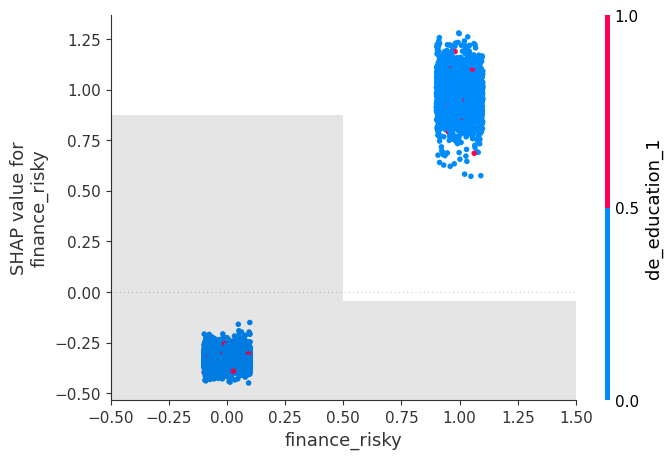

In [70]:
shap.plots.scatter(shap_values[:, "finance_risky"], color=shap_values[:, "de_education_1"])

Wrapping those all in a function.

In [34]:
def full_prediciton():
    df = pd.read_csv('demographic.csv')
    df = df.drop('index', axis=1)
    
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )

    df_bs["join_second"] = pd.to_datetime(df_bs.de_date_joined, dayfirst=True).dt.hour*3600 + pd.to_datetime(df_bs.de_date_joined, dayfirst=True).dt.minute*60
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device

    df_mkt_gsm = pd.read_csv('marketing_gsm_clean.csv')
    df_mkt_gsm = df_mkt_gsm[[
        'device_codename',
        'brand',
        'misc_price',
        'platform_os',
        'launch_status',
        'body_sim',
        'Retail Branding',
    ]]
    df_mkt_gsm['Retail Branding'] = df_mkt_gsm['Retail Branding'].fillna('Unfound')
    df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.replace({'<c2><a3><e2><80><89>141.60 / $<e2><80><89>149.00':'About 180 EUR'})
    df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.str.extract(r"(\d+)")
    df_mkt_gsm.platform_os = df_mkt_gsm.platform_os.map(normalize_os)
    df_mkt_gsm["discontinued"] = df_mkt_gsm.launch_status.str.contains("Discontinued|Cancelled", case=False)
    df_mkt_gsm.body_sim = df_mkt_gsm.body_sim.str.contains('Dual|Triple', case=False)
    df_bs = df_bs.merge(df_mkt_gsm, how='left', on=['device_codename', 'brand'])

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    df_call_log_stats = df_call_log_stats.fillna(0)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob', 'launch_status'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    del X, y

    model = LGBMClassifier(
        colsample_bytree= 0.8,
        learning_rate= 0.05,
        max_depth= 20,
        n_estimators= 300,
        num_leaves= 31,
        scale_pos_weight= None,
        subsample= 0.8
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [35]:
full_prediciton()

/tmp/ipykernel_462074/2231694154.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('demographic.csv')


{'avg_prrc': 0.319293555442372}